# Finding and Removing Invalid Voxels

It is usually necessary to removing various types of invalid voxels prior to performing analysis or simulations on image. PoreSpy includes several functions to help with this process. They are listed below, and each one will be explored in this tutorial. In general there are functions for *finding* invalid pores or voxels, and a matching set for *filling* the invalid locations. 

---
- `find_closed_pores`
- `fill_closed_pores`
---
- `find_surface_pores`
- `fill_surface_pores`
---
- `find_invalid_pores`
- `fill_invalid_pores`
---
- `trim_floating_solid`
---
- `trim_nonpercolating_paths`
---
- `find_disconnected_voxels`
- `trim_disconnected_voxels`
---


## Closed Pores

Closed pores are those which are not connected to any of the faces of the domain. These cause problems when performing simulations since these voids lead to matrices which are ill-conditioned and unsolvable because they are not connected to the main void space.  

In [1]:
from copy import copy

import matplotlib.pyplot as plt

import porespy as ps

cm = copy(plt.cm.bone)

Consider the image below, where grey indicates the void phase and black is the solid phase. We can see by eye that there are many isolated clusters of grey pixels which are completely surrounded by solid. These are "closed" pores.  

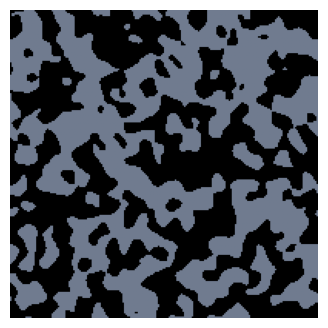

In [2]:
im = ps.generators.blobs([200, 200], blobiness=1.5, porosity=0.5, seed=0)
fig, ax = plt.subplots(figsize=[4, 4])
ax.imshow(im, cmap=cm, vmax=2)
ax.axis(False);

We can identify these closed pores using `find_closed_pores` or we can just go ahead and fill them:

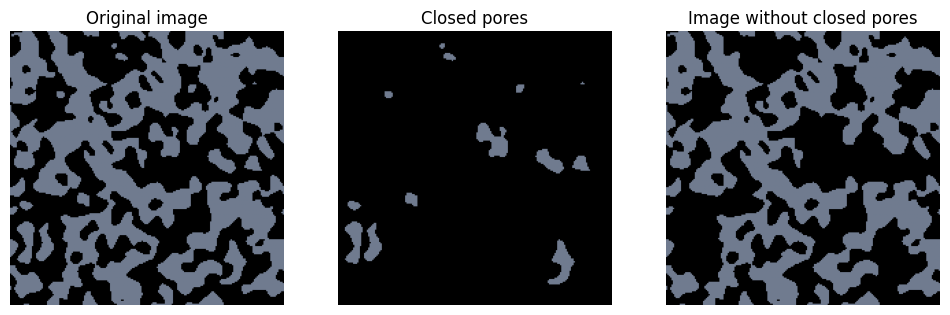

In [3]:
im_filled = ps.filters.fill_closed_pores(im)
im_closed = ps.filters.find_closed_pores(im)

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax[0].imshow(im, cmap=cm, vmax=2)
ax[0].axis(False)
ax[0].set_title('Original image')
ax[1].imshow(im_closed, cmap=cm, vmax=2)
ax[1].axis(False)
ax[1].set_title('Closed pores')
ax[2].imshow(im_filled, cmap=cm, vmax=2)
ax[2].axis(False)
ax[2].set_title('Image without closed pores');

## Surface Pores

Surface pores pose *almost* the same numerical problem as closed pores. The difference is that pores on a surface where boundary conditions are specified are acceptable, but those on the other surfaces are effectively closed. Even pores which are numerically tolerable are still not desirable however, because they do not contribute to transport, hence their inclusion in simulations may skew results. PoreSpy allows for the identification and filling of surface pores:

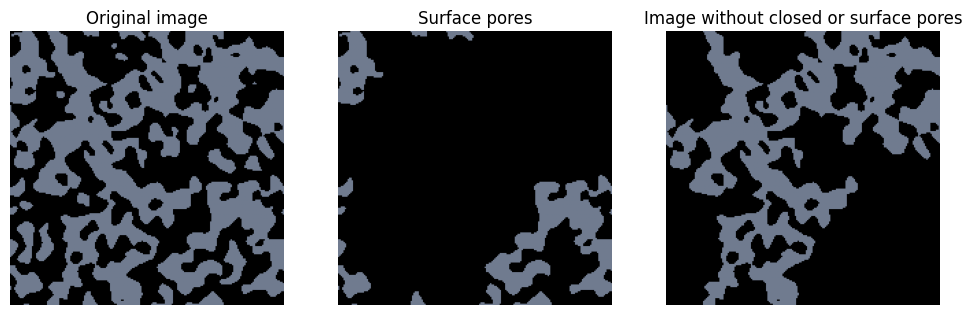

In [4]:
im = ps.generators.blobs([200, 200], blobiness=1.5, porosity=0.5, seed=0)

im_filled = ps.filters.fill_closed_pores(im)
im_surface = ps.filters.find_surface_pores(im_filled)
im_filled = ps.filters.fill_surface_pores(im_filled)

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax[0].imshow(im, cmap=cm, vmax=2)
ax[0].axis(False)
ax[0].set_title('Original image')
ax[1].imshow(im_surface, cmap=cm, vmax=2)
ax[1].axis(False)
ax[1].set_title('Surface pores')
ax[2].imshow(im_filled, cmap=cm, vmax=2)
ax[2].axis(False)
ax[2].set_title('Image without closed or surface pores');

PoreSpy offers functions to find or fill both closed and surface pores called `find_invalid_pores` and `fill_invalid_pores`. The `find_invalid_pores` function returns an image with `1` indicating closed pores and `2` indicating surface pores.

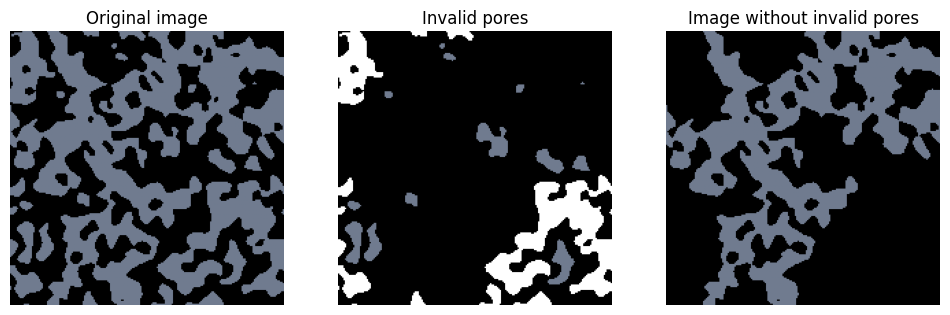

In [5]:
im = ps.generators.blobs([200, 200], blobiness=1.5, porosity=0.5, seed=0)

im_invalid = ps.filters.find_invalid_pores(im)
im_filled = ps.filters.fill_invalid_pores(im)

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax[0].imshow(im, cmap=cm, vmax=2)
ax[0].axis(False)
ax[0].set_title('Original image')
ax[1].imshow(im_invalid, cmap=cm, vmax=2)
ax[1].axis(False)
ax[1].set_title('Invalid pores')
ax[2].imshow(im_filled, cmap=cm, vmax=2)
ax[2].axis(False)
ax[2].set_title('Image without invalid pores');

## Floating solid

Another artifact that can be seen in the above image is the presence of solid voxels which are essentially floating in space because they are not connected to the main body of the solid.  These do not generally cause any numerical difficulties but they are obviously non-physical. If the image was obtained by thresholding a greyscale image (e.g. a tomogram) then this may indicate that the threshold was not quite right. In any event, they are worth removing.

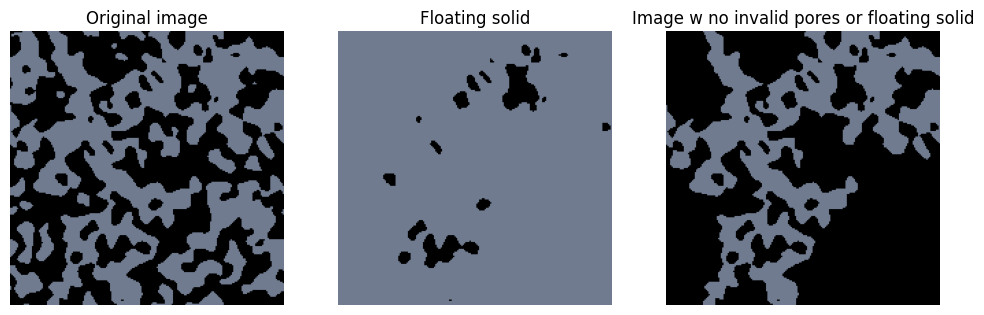

In [6]:
im = ps.generators.blobs([200, 200], blobiness=1.5, porosity=0.5, seed=0)

im_filled = ps.filters.fill_invalid_pores(im)
im_floating = ps.filters.find_floating_solid(im_filled)
im_trimmed = ps.filters.trim_floating_solid(im_filled)

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax[0].imshow(im, cmap=cm, vmax=2)
ax[0].axis(False)
ax[0].set_title('Original image')
ax[1].imshow(~im_floating, cmap=cm, vmax=2)
ax[1].axis(False)
ax[1].set_title('Floating solid')
ax[2].imshow(im_trimmed, cmap=cm, vmax=2)
ax[2].axis(False)
ax[2].set_title('Image w no invalid pores or floating solid');

## Non-Percolating Paths

Surface pores are defined

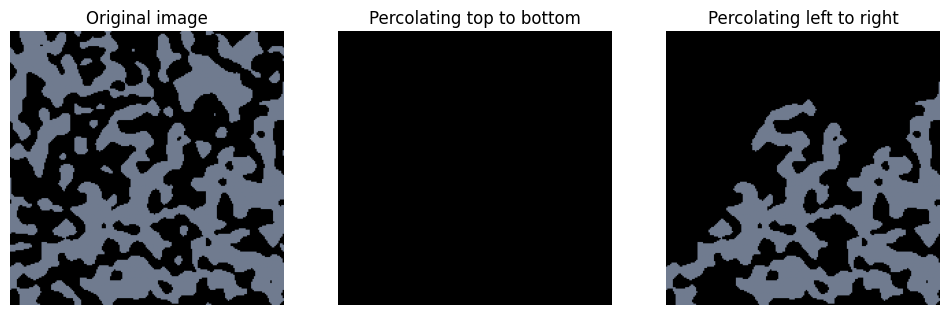

In [7]:
im = ps.generators.blobs([200, 200], blobiness=1.5, porosity=0.5, seed=1)

im_trimmed = ps.filters.trim_floating_solid(im)
im_filled_ud = ps.filters.trim_nonpercolating_paths(im_trimmed, axis=0)
im_filled_lr = ps.filters.trim_nonpercolating_paths(im_trimmed, axis=1)

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax[0].imshow(im, cmap=cm, vmax=2)
ax[0].axis(False)
ax[0].set_title('Original image')
ax[1].imshow(im_filled_ud, cmap=cm, vmax=2)
ax[1].axis(False)
ax[1].set_title('Percolating top to bottom')
ax[2].imshow(im_filled_lr, cmap=cm, vmax=2)
ax[2].axis(False)
ax[2].set_title('Percolating left to right');

## General voxel connectivity

The method discussed so far all make common assumptions for convenience, like assuming that percolation implies that the voids span the domain.  PoreSpy offers the `find_disconnected_voxels` and `fill_disconnected_voxels` function to allow for the control over how connected is defined via the `inlets` argument.

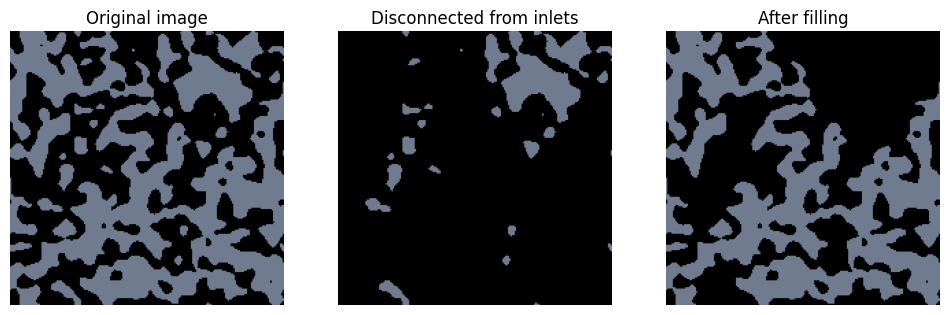

In [9]:
im = ps.generators.blobs([200, 200], blobiness=1.5, porosity=0.5, seed=1)

inlets = ps.generators.faces(im.shape, inlet=1)
im_disconnected = ps.filters.find_disconnected_voxels(im, inlets=inlets)
im_filled = ps.filters.trim_disconnected_voxels(im, inlets=inlets)

fig, ax = plt.subplots(1, 3, figsize=[12, 4])
ax[0].imshow(im, cmap=cm, vmax=2)
ax[0].axis(False)
ax[0].set_title('Original image')
ax[1].imshow(im_disconnected, cmap=cm, vmax=2)
ax[1].axis(False)
ax[1].set_title('Disconnected from inlets')
ax[2].imshow(im_filled, cmap=cm, vmax=2)
ax[2].axis(False)
ax[2].set_title('After filling');